In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16

In [3]:
from tensorflow.keras.preprocessing import image

In [4]:
import tensorflow_datasets as tfds
%load_ext tensorboard

tfds.disable_progress_bar()

In [5]:
#[90% of data for training, 10% for validation]
split_train, split_valid = tfds.Split.TRAIN.subsplit(weighted=[9,1])

In [6]:
train,info_train = tfds.load(name = 'cats_vs_dogs',split = split_train,with_info=True)
valid, info_valid = tfds.load(name = 'cats_vs_dogs',split = split_valid,with_info=True)


In [7]:
num_examples = info_train.splits['train']

In [8]:
print(f'length of train examples {num_examples}')

length of train examples <tfds.core.SplitInfo num_examples=23262>


In [9]:
train_examples = info_train.splits['train'].num_examples*0.9

In [10]:
print(f'length of train examples {train_examples}')

length of train examples 20935.8


In [11]:
valid_examples = info_train.splits['train'].num_examples*0.1

In [12]:
print(f'length of train examples {valid_examples}')

length of train examples 2326.2000000000003


In [13]:
IMG_H, IMG_W, IMG_CHANNELS =info_train.features['image'].shape

In [14]:
info_train.features['image'].shape

(None, None, 3)

In [15]:
def preprocess(ds):
    x = tf.image.resize_with_pad(ds['image'], IMG_SIZE, IMG_SIZE)
    x = tf.cast(x, tf.float32)
    x = (x / 127.5) - 1
    return x, ds['label']


In [53]:
# Variables
BATCH_SIZE = 32
NUM_EPOCHS = 3
IMG_H = IMG_W = 256
IMG_SIZE = 256
LOG_DIR = '.\log' # for linux './log'
DEGREES = 10  #for rotation
SHUFFLE_BUFFER_SIZE = 1024
IMG_CHANNELS = 3


In [17]:
train1 = train.cache().map(preprocess).repeat().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [35]:
val = valid.cache().map(preprocess).batch(BATCH_SIZE)

In [19]:
val

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int64)>

In [20]:
def augmentation(image, label): 
    # https://www.tensorflow.org/tutorials/images/data_augmentation
    
    image = tf.image.random_brightness(image, .1)
    image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
    image = tf.image.random_flip_left_right(image)
    return image, label


In [21]:
train1 = train1.map(augmentation).prefetch(tf.data.experimental.AUTOTUNE)
# tf.data.experimental.AUTOTUNE -> find ideal parameters
# prefetch -> to make the pipeline in asyn mode,
# Prefetching overlaps the preprocessing and model execution of a training step
# https://www.tensorflow.org/guide/data_performance

In [22]:
import math
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import CSVLogger


In [23]:
import numpy as np

In [24]:
## to load model without classifier layers part -> include_top=False
model_vgg = VGG16(include_top = False,input_shape = (256,256,3))

In [25]:
model_vgg.trainable = False


In [26]:
model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [27]:
from tensorflow.keras.layers import Flatten,Dense

In [28]:
flat1 = Flatten()
class1 = Dense(5120, activation='relu')
class2 = Dense(1024, activation='relu')
output = Dense(2, activation='softmax')

In [29]:
model = tf.keras.Sequential([model_vgg,flat1,class1,class2,output])


In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 5120)              167777280 
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              5243904   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 187,737,922
Trainable params: 173,023,234
Non-trainable params: 14,714,688
_________________________________________________________________


In [59]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(LOG_DIR,histogram_freq=1,write_graph=True,write_grads=True,batch_size = BATCH_SIZE, write_images = True,profile_batch = 5)
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
csv_logger = CSVLogger('colorectal-transferlearn-' + 'log.csv',append=True,separator=';')


In [32]:
NUM_CLASSES = 2
learning_rate = 0.001


In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',metrics=["accuracy"])

* https://jovianlin.io/cat-crossentropy-vs-sparse-cat-crossentropy/
* https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

In [60]:
model.fit(train1,epochs=NUM_EPOCHS,
        steps_per_epoch=int(train_examples / BATCH_SIZE),validation_data=val,
        validation_steps=int(valid_examples/BATCH_SIZE),
        callbacks=[tensorboard_callback, earlystop_callback, csv_logger])
 

Train for 654 steps, validate for 72 steps
Epoch 1/3
654/654 [==============================] - 248s 379ms/step - loss: 0.2212 - accuracy: 0.8929 - val_loss: 0.1081 - val_accuracy: 0.9596
Epoch 2/3
654/654 [==============================] - 253s 386ms/step - loss: 0.1925 - accuracy: 0.9065 - val_loss: 0.1118 - val_accuracy: 0.9614
Epoch 3/3
654/654 [==============================] - 241s 368ms/step - loss: 0.1879 - accuracy: 0.9092 - val_loss: 0.1077 - val_accuracy: 0.9622


In [61]:
img = image.load_img('cat1.png',target_size=(256,256))

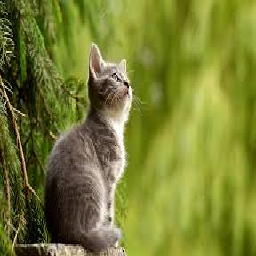

In [62]:
img

In [63]:
# convert image to array
img = image.img_to_array(img)

In [64]:
# method 2 : expand function -> https://github.com/fchollet/deep-learning-models
img = np.expand_dims(img, axis=0) # 0 means first index in row [0,1,2,3,4]

In [65]:
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions


In [66]:
img = preprocess_input(img)

In [67]:
print(model.predict(img))
print(model.predict_classes(img))

[[1.000000e+00 1.178418e-23]]
[0]


In [69]:
%tensorboard --logdir '.\log'


Reusing TensorBoard on port 6006 (pid 15996), started 0:01:01 ago. (Use '!kill 15996' to kill it.)